In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

from satforecast.data import data
from satforecast.modeling.model_selection import rolling_batch
from satforecast.modeling.train import train

data.download()
image_dir = data.process_gs_rainfall_daily(scale=0.1)
image_files = data.get_files(image_dir, '*.npy')

In [8]:
class PermuteLayer(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

class FlattenLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.flatten(start_dim=1, end_dim=-1)

class CNN3D(nn.Module):
    def __init__(self,
            seq_len = 5, # Data
            image_size = (60, 180),
            in_channels = 1, # Conv
            conv_channels = 2,
            conv_kernels = 3,
            conv_stride = 3,
            conv_padding = 1,
            pool_kernels = 2, # Pool
            pool_stride = 2,
            pool_padding = 1,
            linear_feats = [] # Linear
    ):
        super().__init__()
        
        # Permute and flatten layers
        # Input: (batch_size, seq_len, n_channels, height, width)
        input_to_conv3d = (0, 2, 1, 3, 4) # (batch_size, n_channels, seq_len, height, width)
        input_to_conv3d_permute = PermuteLayer(input_to_conv3d)
        conv3d_to_flatten = (0, 2, 3, 4, 1) # (batch_size, seq_len, height, width, x_channels)
        conv3d_to_flatten_permute = PermuteLayer(conv3d_to_flatten)
        flatten = FlattenLayer() # (batch_size, seq_len * height * width, x_channels)
        #conv3d_to_flatten_permute = PermuteLayer(conv3d_to_linear)
        
        # Flatten layer
        

        # Convolutional layers
        if type(conv_channels) is int:
            conv_channels = [conv_channels]

        conv_steps = len(conv_channels)

        if type(conv_kernels) is int:
            conv_kernels = [conv_kernels] * conv_steps
            conv_stride = [conv_stride] * conv_steps
            conv_padding = [conv_padding] * conv_steps
            pool_kernels = [pool_kernels] * conv_steps
            pool_stride = [pool_stride] * conv_steps
            pool_padding = [pool_padding] * conv_steps

        conv_layers = []
        for in_c, out_c, c_kern, c_stride, c_pad, p_kern, p_stride, p_pad in zip(
                [in_channels] + conv_channels[:-1],
                conv_channels,
                conv_kernels, conv_stride, conv_padding,
                pool_kernels, pool_stride, pool_padding
        ):
            conv_layers.extend([
                nn.Conv3d(in_c, out_c, c_kern, c_stride, c_pad),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(p_kern, p_stride, p_pad)
            ])

        # Calculate output shape of convolutional layers
        with torch.no_grad():
            test_tensor = torch.zeros(1, seq_len, in_channels, image_size[0], image_size[1])
            test_tensor = input_to_conv3d_permute(test_tensor)
            test_tensor = nn.Sequential(*conv_layers)(test_tensor)
            test_tensor = conv3d_to_flatten_permute(test_tensor)
            test_tensor = flatten(test_tensor)
            conv_output_shape = test_tensor.shape

        # Fully connected layers
        if type(linear_feats) is int:
            linear_feats = [linear_feats]

        linear_feats = [
            np.prod(conv_output_shape),
            *linear_feats,
            in_channels * np.prod(image_size)
        ]

        fc_layers = []
        for in_feats, out_feats in zip(linear_feats[:-1], linear_feats[1:]):
            fc_layers.extend([
                nn.Linear(in_feats, out_feats),
                nn.ReLU(inplace=True)
            ])

        # Full Model
        self.model = nn.Sequential(
            input_to_conv3d_permute, *conv_layers,
            conv3d_to_flatten_permute, flatten, *fc_layers
        )

    def forward(self, x):
        batch_size, _, n_channels, height, width = x.shape
        return self.model(x).view(batch_size, n_channels, height, width)
    
    def predict(self, x):
        return self.forward(x)

[1] [2] [3] [3] [1] [2] [2] [1]
1 2 3 3 1 2 2 1
CNN3D(
  (model): Sequential(
    (0): PermuteLayer()
    (1): Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(1, 1, 1))
    (2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): PermuteLayer()
    (6): FlattenLayer()
    (7): Linear(in_features=1364, out_features=10800, bias=True)
    (8): ReLU(inplace=True)
  )
)
Batch 0: Validation loss = 0.07229840010404587, Train time = 0.0, Update time = 0.2, Validation time = 0.0
Batch 1: Validation loss = 0.07521688938140869, Train time = 0.0, Update time = 0.2, Validation time = 0.0

!!! Early stopping triggered after 0 epochs and 2 batches !!!



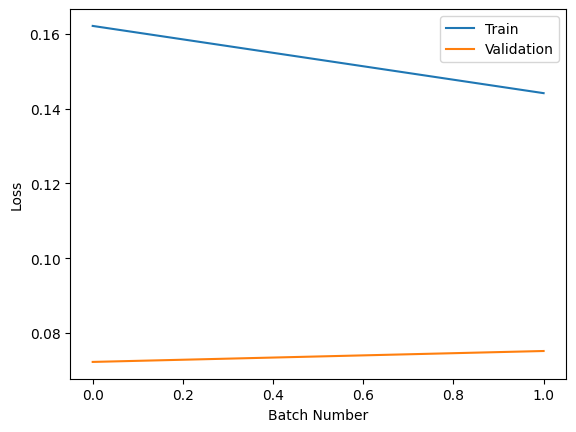

In [9]:
# Test run
TEST_N_IMAGES = 100
test_image_files = image_files[:TEST_N_IMAGES]
test_cnn3d = CNN3D(
    seq_len = 5, # Data
    image_size = (60, 180),
    in_channels = 1, # Conv
    conv_channels = 2,
    conv_kernels = 3,
    conv_stride = 3,
    conv_padding = 1,
    pool_kernels = 2, # Pool
    pool_stride = 2,
    pool_padding = 1,
    linear_feats = [] # Linear
)

print(test_cnn3d)

train_loss, val_loss = train(
    model = test_cnn3d,
    model_name = 'test_cnn3d_v0',
    criterion = nn.MSELoss(),
    optimizer = torch.optim.Adam(test_cnn3d.parameters()),
    files_list = test_image_files,
    train_frac = 0.6,
    val_frac = 0.1,
    seq_len = 5,
    batch_size = 5,
    max_epochs = 3,
    val_level = 'batch',
    early_stopping = True,
    min_improv = 0.003,
    max_iter_improv = 1,
    log_level = 1
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

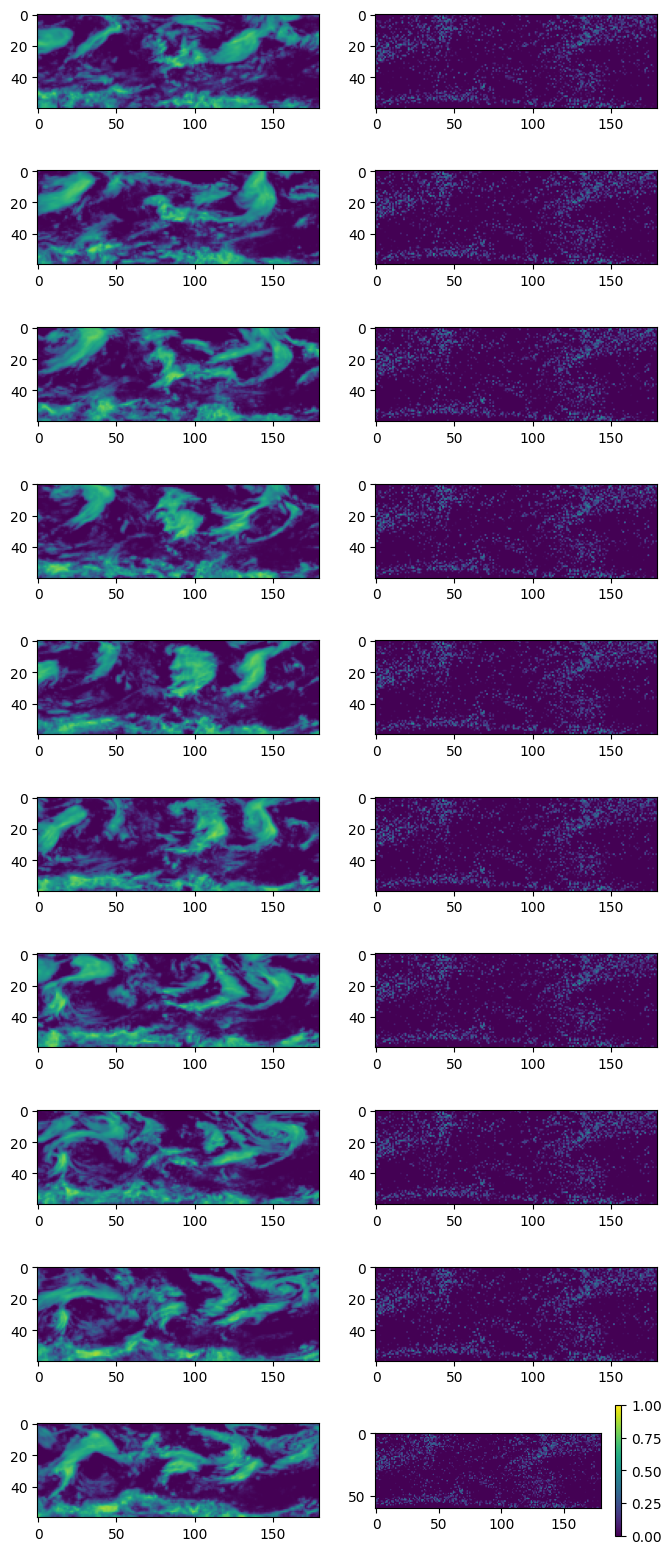

In [26]:
N_DAYS = 10
COLS = 2
IMAGE_SIZE = (60, 180)

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(8, 2*N_DAYS))

test_cnn3d.eval()

SEQ_LEN = 5
for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[TEST_N_IMAGES + i: TEST_N_IMAGES + i + SEQ_LEN + 1], start=0, stop=SEQ_LEN + 1, seq_len=SEQ_LEN)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(test_cnn3d.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y.astype('float32'), vmin=0, vmax=1)

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred.astype('float32'), vmin=0, vmax=1)

plt.colorbar();

## Semi-full training

[1, 2] [2, 5] [(2, 5, 5), (2, 5, 5)] [(1, 5, 5), (2, 2, 2)] [0, 1, 1] [2, 2] [2, 2] [0]
1 2 (2, 5, 5) (1, 5, 5) 0 2 2 0
Model will be saved to /home/jmlazaro/data_science/satellite-forecast/models/dev_cnn3d_v0.12.pth
Time to make validation tensors: 0.0318601131439209
Size of X_val = 0.019GB , Size of y_val = 0.004GB 
Batch 0: Validation loss = 0.07699468731880188, Train time = 0.0, Update time = 0.2, Validation time = 0.0
Batch 1: Validation loss = 0.07688844949007034, Train time = 0.0, Update time = 0.1, Validation time = 0.0
Batch 2: Validation loss = 0.0767863392829895, Train time = 0.0, Update time = 0.1, Validation time = 0.0
Batch 3: Validation loss = 0.07668381184339523, Train time = 0.0, Update time = 0.1, Validation time = 0.0
Batch 4: Validation loss = 0.0765765905380249, Train time = 0.0, Update time = 0.1, Validation time = 0.0
Batch 5: Validation loss = 0.07646972686052322, Train time = 0.0, Update time = 0.1, Validation time = 0.0
Batch 6: Validation loss = 0.07636351138

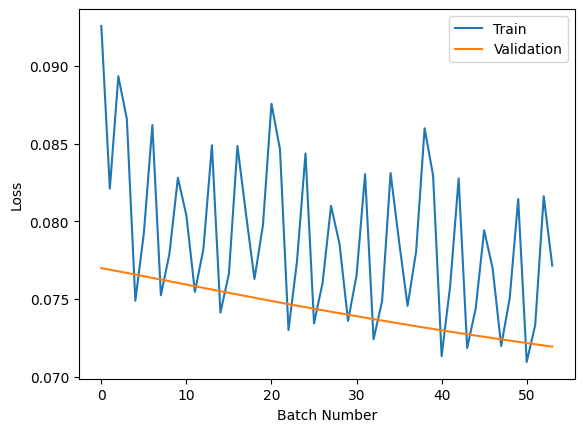

In [30]:
# Data constants
DEV_N_IMAGES = 2_000
TRAIN_FRAC = 0.95
VAL_FRAC = 0.05
SEQ_LEN = 5

dev_image_files = image_files[:DEV_N_IMAGES]

# Model
dev_cnn3d = CNN3D(
    seq_len = SEQ_LEN, # Data
    image_size = (60, 180),
    in_channels = 1, # Conv
    conv_channels = [2, 5],
    conv_kernels = [(2, 5, 5),(2, 5, 5)],
    conv_stride = [(1, 5, 5),(2, 2, 2)],
    conv_padding = [0, 1, 1],
    pool_kernels = [2,2], # Pool
    pool_stride = [2,2],
    pool_padding = [0],
    linear_feats = [5] # Linear
)
model_name = 'dev_cnn3d_v0'
crit = nn.MSELoss()
optim = torch.optim.Adam(dev_cnn3d.parameters())

# Training constants
BATCH_SIZE = 100
MAX_EPOCHS = 3
MIN_IMPROV = 0.000
MAX_ITER_IMPROV = 3

train_loss, val_loss = train(
    model = dev_cnn3d,
    model_name = model_name,
    criterion = crit,
    optimizer = optim,
    files_list = dev_image_files,
    train_frac = TRAIN_FRAC,
    val_frac = VAL_FRAC,
    seq_len = SEQ_LEN,
    batch_size = BATCH_SIZE,
    max_epochs = MAX_EPOCHS,
    val_level = 'batch',
    early_stopping = False,
    min_improv = MIN_IMPROV,
    max_iter_improv = MAX_ITER_IMPROV,
    log_level = 2
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

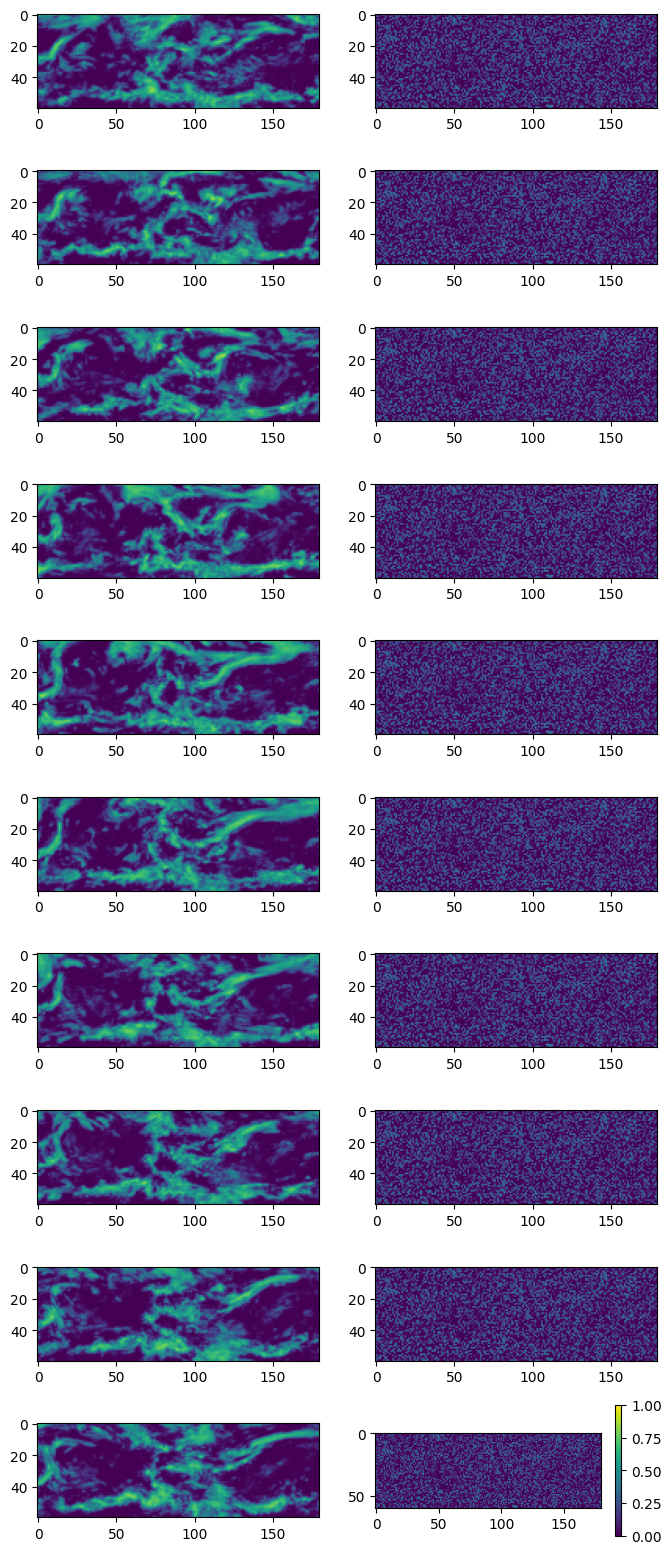

In [31]:
N_DAYS = 10
COLS = 2
IMAGE_SIZE = (60, 180)

fig, axs = plt.subplots(N_DAYS, COLS, figsize=(8, 2*N_DAYS))

dev_cnn3d.eval()

for i in range(N_DAYS):

    # Get predicted
    X, y = rolling_batch(image_files[DEV_N_IMAGES + i: DEV_N_IMAGES + i + SEQ_LEN + 1], start=0, stop=SEQ_LEN + 1, seq_len=SEQ_LEN)
    y = torch.reshape(y, IMAGE_SIZE).numpy()
    y_pred = torch.reshape(dev_cnn3d.predict(X), IMAGE_SIZE).detach().numpy()

    # Plot real
    plt.subplot(N_DAYS, COLS, i * COLS + 1)
    plt.imshow(y.astype('float32'), vmin=0, vmax=1)

    # Plot predicted
    plt.subplot(N_DAYS, COLS, i * COLS + 2)
    plt.imshow(y_pred.astype('float32'), vmin=0, vmax=1)

plt.colorbar();